In [1]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

Explore data

In [2]:
data = pd.read_csv("../data/thailand.csv", index_col=0, parse_dates=True)
data.tail()

,daily_cases
date,
2021-01-31,829
2021-02-01,836
2021-02-02,836
2021-02-03,795
2021-02-04,809


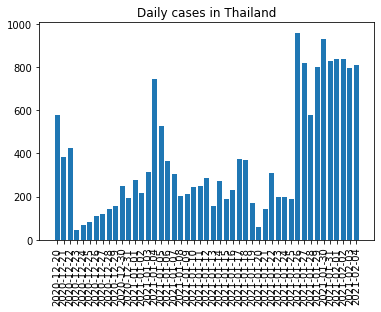

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(data.index, data["daily_cases"])
ax.set_title("Daily cases in Thailand")
ax.set_xticks(data.index)
plt.xticks(rotation=90);

Convert date axis to integers and perform curve fit using scipy

In [4]:
x = data.index.to_julian_date().values
x0 = x[0]
y = data["daily_cases"].values
x-x0, y

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46.]),
 array([576, 382, 427,  46,  67,  81, 110, 121, 144, 155, 250, 194, 279,
        216, 315, 745, 527, 365, 305, 205, 212, 245, 249, 287, 157, 271,
        188, 230, 374, 369, 171,  59, 142, 309, 198, 198, 187, 959, 819,
        576, 802, 930, 829, 836, 836, 795, 809]))

In [5]:
from scipy.optimize import curve_fit
model = lambda t,a,b: a + b*t
popt, pcov = curve_fit(model,  x-x0,  y)
popt

array([109.75797872,  11.46010638])

Check curve fit goodness by visual inspection

In [6]:
data["daily_cases_fit"] = model(x-x0, *popt)
data["total_cases_fit"] = data["daily_cases_fit"].cumsum()

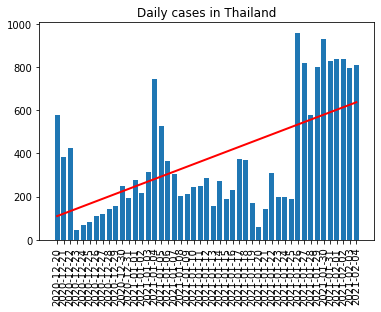

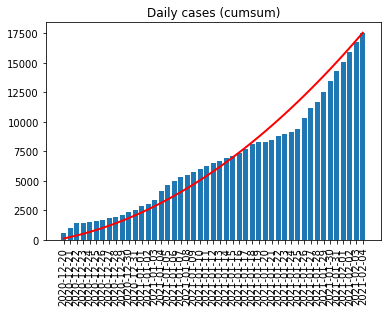

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(data.index, data["daily_cases"])
ax.set_title("Daily cases in Thailand")
ax.set_xticks(data.index)
plt.xticks(rotation=90);
ax.plot(data.index, data["daily_cases_fit"], '-r', lw=2)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(data.index, data["daily_cases"].cumsum())
ax.set_title("Daily cases (cumsum)")
ax.set_xticks(data.index)
plt.xticks(rotation=90);
ax.plot(data.index, data["total_cases_fit"], '-r', lw=2)

LGTM. Let's use curve fit to predict data to the next 10 days.

In [8]:
day_start = data.index[-1] + pd.Timedelta("1 d")
day_end = day_start + pd.Timedelta("10 d")
#day_end = pd.Timestamp("2021-01-13")
new_index = pd.date_range(day_start, day_end)
new_index

DatetimeIndex(['2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08',
               '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-13', '2021-02-14', '2021-02-15'],
              dtype='datetime64[ns]', freq='D')

In [9]:
prediction = model(new_index.to_julian_date() - x0, *popt)
data2 = pd.DataFrame(prediction, index=new_index, columns=["daily_cases_fit"])
data2["total_cases_fit"] = data["daily_cases"].sum() + data2["daily_cases_fit"].cumsum()
data2

,daily_cases_fit,total_cases_fit
2021-02-05,648.382979,18195.382979
2021-02-06,659.843085,18855.226064
2021-02-07,671.303191,19526.529255
2021-02-08,682.763298,20209.292553
2021-02-09,694.223404,20903.515957
2021-02-10,705.683511,21609.199468
2021-02-11,717.143617,22326.343085
2021-02-12,728.603723,23054.946809
2021-02-13,740.063830,23795.010638
2021-02-14,751.523936,24546.534574


Create visualization combining data, fit and prediction

2021-02-04, f(x) = 109.758 + 11.4601 * t
[18618. 18619. 18620. 18621. 18622. 18623. 18624. 18625. 18626. 18627.
 18628. 18629. 18630. 18631. 18632. 18633. 18634. 18635. 18636. 18637.
 18638. 18639. 18640. 18641. 18642. 18643. 18644. 18645. 18646. 18647.
 18648. 18649. 18650. 18651. 18652. 18653. 18654. 18655. 18656. 18657.
 18658. 18659. 18660. 18661. 18662. 18663. 18664. 18665. 18666. 18667.
 18668. 18669. 18670. 18671. 18672. 18673. 18674.]


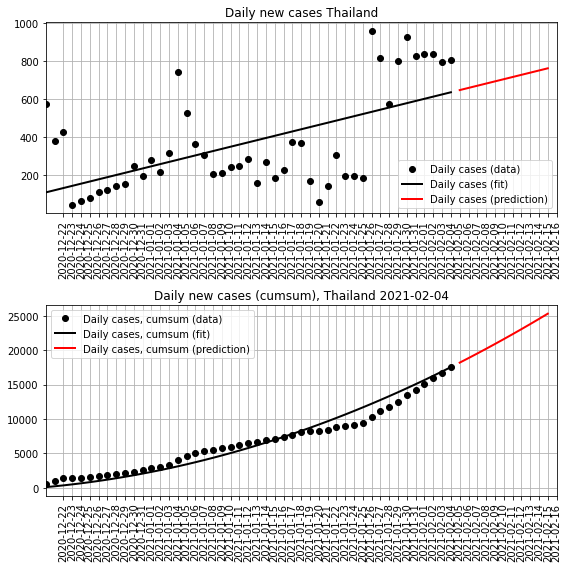

In [10]:
combindex = data.index.union(data2.index)
datestamp = data.index[-1].strftime("%Y-%m-%d")

equation = "%g + %g * t" % (popt[0], popt[1])
eqstr = "%s, f(x) = %s" % (datestamp, equation)
print(eqstr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(data.index, data["daily_cases"], "ko", label="Daily cases (data)")
ax1.set_title("Daily new cases Thailand")
ax1.plot(data.index, data["daily_cases_fit"], '-k', lw=2, label="Daily cases (fit)")
ax1.plot(data2.index, data2["daily_cases_fit"], '-r', lw=2, label="Daily cases (prediction)")
ax1.grid()
ax1.set_xlim(data.index[0], data2.index[-1])
xticks = ax1.get_xticks()
xticks = np.arange(xticks[0], xticks[-1]+2)
print(xticks)
ax1.set_xticks(xticks)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.legend()

ax2.plot(data.index, data["daily_cases"].cumsum(), "ko", label="Daily cases, cumsum (data)")
ax2.plot(data.index, data["total_cases_fit"], '-k', lw=2, label="Daily cases, cumsum (fit)")
ax2.plot(data2.index, data2["total_cases_fit"], '-r', lw=2, label="Daily cases, cumsum (prediction)")
ax2.set_title("Daily new cases (cumsum), Thailand %s" % datestamp)
ax2.grid()
ax2.set_xlim(data.index[0], data2.index[-1])
ax2.set_xticks(xticks)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.legend()

fig.tight_layout()
fig.savefig("../figs/%s-prediction.png" % datestamp)
fig.savefig("../figs/%s-prediction.svg" % datestamp)